sources:

- https://www.kaggle.com/code/kamyarazar/stock-price-prediction-lstm-hyperparameter-tuning/notebook
- https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from helpers import read_data

hist = read_data(start_date="2021-11-01", end_date="2023-11-01")
close = hist["Close"]

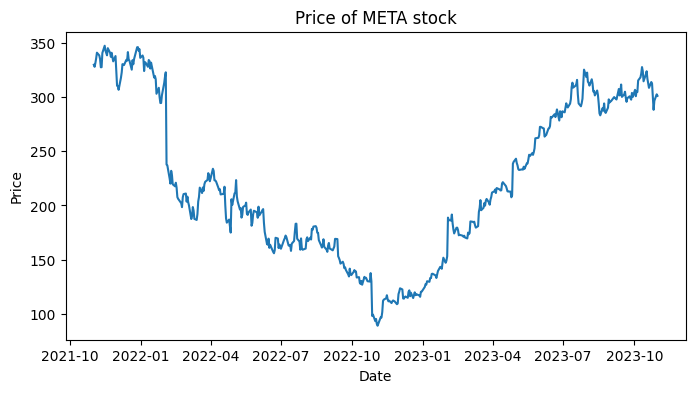

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(close)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price of META stock")
plt.show()

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from helpers import create_dataset

scaler = MinMaxScaler()
close_normalized = scaler.fit_transform(np.array(close).reshape(-1, 1))

train, test = train_test_split(
    close_normalized, test_size=0.2, random_state=69, shuffle=False
)

period = 15  # period
n_features = 1  # 1 because I only have the closing price

X_train, y_train = create_dataset(train, period)
X_test, y_test = create_dataset(test, period)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

3/3 [==============================] - 1s 4ms/step
units = 50, batch_size = 32, epochs = 50
MAE = 8.24216088583303
MAPE = 0.02724736743724715
RMSE = 10.44303011799044
3/3 [==============================] - 1s 5ms/step
units = 50, batch_size = 32, epochs = 100
MAE = 6.96158333711846
MAPE = 0.02281803254705936
RMSE = 8.752402191546906
3/3 [==============================] - 1s 4ms/step
units = 50, batch_size = 32, epochs = 200
MAE = 5.094233313272167
MAPE = 0.01673741236981343
RMSE = 6.600537379989012
3/3 [==============================] - 1s 6ms/step
units = 50, batch_size = 64, epochs = 50
MAE = 14.30419070221657
MAPE = 0.04662130704016973
RMSE = 16.769360319733202
3/3 [==============================] - 1s 6ms/step
units = 50, batch_size = 64, epochs = 100
MAE = 11.797351925872094
MAPE = 0.038545143733090745
RMSE = 13.935561691156693
3/3 [==============================] - 1s 5ms/step
units = 50, batch_size = 64, epochs = 200
MAE = 11.597388334052509
MAPE = 0.03794795916582776
RMSE = 13.

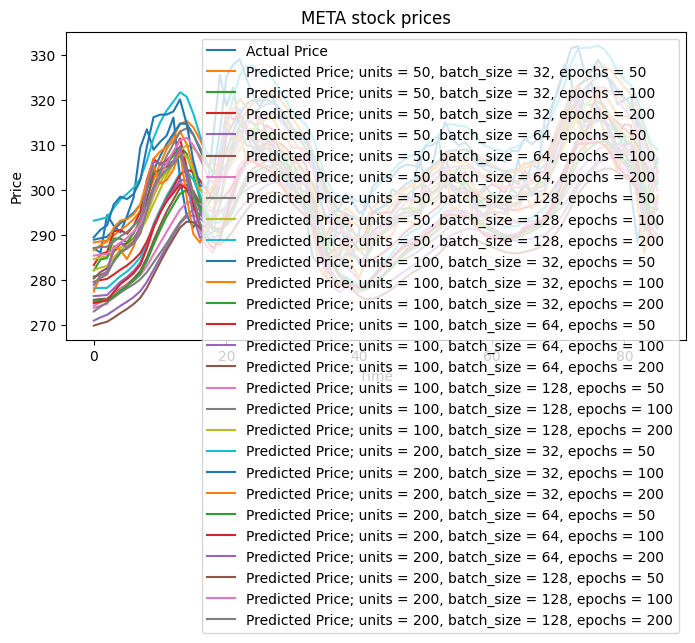

In [9]:
from helpers import create_model_simpler, create_model_original, get_stats

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
for units in [50, 100, 200]:
    for batch_size in [32, 64, 128]:
        for epochs in [50, 100, 200]:
            original_model = create_model_simpler(units=units, period=period)
            original_model.fit(
                X_train,
                y_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                validation_split=0.2,
            )
            y_pred = original_model.predict(X_test)
            # inverse normalization
            y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))

            print(f"units = {units}, batch_size = {batch_size}, epochs = {epochs}")
            MAE, MAPE, RMSE = get_stats(y_test_original, y_pred_original)

3/3 [==============================] - 2s 28ms/step
MAE = 12.604375440020894
MAPE = 0.04120713327624704
RMSE = 14.114019600434453
420
3/3 [==============================] - 1s 5ms/step
MAE = 5.38681633527889
MAPE = 0.017679573428343868
RMSE = 7.0366286976061705


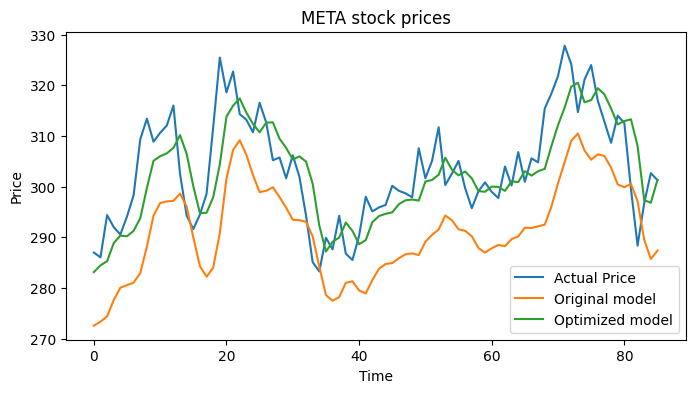

In [24]:
plt.figure(figsize=(8, 4))

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_test_original, label="Actual Price")

original_model = create_model_original(units=200, period=period)
original_model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    verbose=0,
    validation_split=0.2,
)
y_pred = original_model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
get_stats(y_test_original, y_pred_original)
plt.plot(
    y_pred_original,
    label="Original model",
)


updated_model = create_model_simpler(units=50, period=period)
updated_model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
)
y_pred = updated_model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
get_stats(y_test_original, y_pred_original)
plt.plot(
    y_pred_original,
    label="Optimized model",
)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("META stock prices")
plt.legend()
plt.show()

In [25]:
import pandas as pd

results_dict = {
    "Day": [],
    "Action": [],
    "Buy Price": [],
    "Predicted Price": [],
    "Real Price Next Day": [],
    "Profit": [],
    "Portfolio Balance": [],
}

portfolio_balance = 10000

_, final_test = train_test_split(hist, test_size=0.2, random_state=69, shuffle=False)

real_close_prices = final_test["Close"][period:]
real_open_prices = final_test["Open"][period:]
real_date = final_test.index[period:]
final_preds = y_pred_original

for i in range(len(real_close_prices) - 1):
    current_price = real_close_prices.iloc[i]
    next_day_predicted = final_preds[i + 1][0]
    next_day_real = real_open_prices.iloc[i + 1]

    if next_day_predicted >= current_price:
        action = "Buy Long"
        profit = (next_day_real - current_price) / current_price * portfolio_balance
    else:
        action = "Short Sell"
        profit = (current_price - next_day_real) / current_price * portfolio_balance

    portfolio_balance += profit

    results_dict["Day"].append(real_date[i])
    results_dict["Action"].append(action)
    results_dict["Buy Price"].append(current_price)
    results_dict["Predicted Price"].append(next_day_predicted)
    results_dict["Real Price Next Day"].append(next_day_real)
    results_dict["Profit"].append(profit)
    results_dict["Portfolio Balance"].append(portfolio_balance)

results_df = pd.DataFrame(results_dict)

pd.set_option("display.max_rows", None)
display(results_df)
pd.reset_option("display.max_rows")

,Day,Action,Buy Price,Predicted Price,Real Price Next Day,Profit,Portfolio Balance
0,2023-06-30 00:00:00-04:00,Short Sell,286.980011,284.451294,286.700012,9.756735,10009.756735
1,2023-07-03 00:00:00-04:00,Short Sell,286.019989,285.270081,287.649994,-57.044797,9952.711937
2,2023-07-05 00:00:00-04:00,Short Sell,294.369995,288.834320,295.890015,-51.392183,9901.319754
3,2023-07-06 00:00:00-04:00,Short Sell,291.989990,290.316193,292.179993,-6.442943,9894.876811
4,2023-07-07 00:00:00-04:00,Short Sell,290.529999,290.195129,295.549988,-170.970891,9723.905920
5,2023-07-10 00:00:00-04:00,Short Sell,294.100006,291.263031,293.899994,6.613056,9730.518976
6,2023-07-11 00:00:00-04:00,Short Sell,298.290009,293.749420,301.750000,-112.868388,9617.650588
7,2023-07-12 00:00:00-04:00,Short Sell,309.339996,299.711945,313.619995,-133.068899,9484.581689
8,2023-07-13 00:00:00-04:00,Short Sell,313.410004,305.101776,311.790009,49.025161,9533.606850
9,2023-07-14 00:00:00-04:00,Short Sell,308.869995,305.999329,307.540009,41.051476,9574.658326
